<a href="https://colab.research.google.com/github/Ritviks21/Silicon-Sentinel/blob/main/Silicon_Sentinel_Training_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Libraries

In [4]:
!pip install ultralytics opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

from ultralytics import YOLO

# --- Load the upgraded YOLOv8s model ---
model = YOLO('yolov8s.pt')

# --- Define the Google Drive save path ---
drive_project_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs'

# --- Start the final training ---
print("🚀 Starting the FINAL model training with YOLOv8s, full augmentation, and 75 epochs...")
results = model.train(
    data='ultimate_data_for_training/data.yaml',
    epochs=75,         # Increased for better learning
    imgsz=640,
    degrees=15,        # Data augmentation
    translate=0.1,
    scale=0.1,
    fliplr=0.5,
    project=drive_project_path,
    name='Silicon_Sentinel_v1.0' # Final model name
)

print("✅ FINAL training complete!")
print(f"Model and results are permanently saved in your Google Drive at: {results.save_dir}")

Final Data Generation Script

In [21]:
import os
import cv2
import numpy as np
import random
import shutil
import math

# --- Configuration ---
DATASET_PATH = 'ultimate_wafer_dataset'
NUM_IMAGES = 2500
IMG_WIDTH = 640
IMG_HEIGHT = 640
defect_classes = {"scratch": 0, "particle": 1, "blob": 2}

# --- Helper Functions ---

def create_base_wafer():
    """
    Creates a more realistic, textured silicon wafer background with variations
    to prevent the model from overfitting to a single background pattern.
    """
    bg_type = random.choice(['smooth', 'grainy', 'gradient'])
    base_color = random.randint(45, 60)
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), base_color, dtype=np.uint8)

    if bg_type == 'grainy':
        noise = np.random.normal(0, 3, (IMG_HEIGHT, IMG_WIDTH, 3)).astype(np.int16)
        image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        image = cv2.GaussianBlur(image, (3, 3), 0)
    elif bg_type == 'gradient':
        end_color = base_color - random.randint(10, 20)
        c = np.linspace(base_color, end_color, IMG_WIDTH, dtype=np.uint8)
        image[:, :, :] = c[np.newaxis, :, np.newaxis]

    # Add a subtle color tint to mimic silicon
    tint_color = np.array([1.0, 1.0, random.uniform(1.0, 1.05)])
    image = np.clip(image * tint_color, 0, 255).astype(np.uint8)
    return image

def add_advanced_scratch(image):
    """
    Generates straight, curved, or wavy scratches to teach the model to
    differentiate from simple background lines.
    """
    start_x, start_y = random.randint(50, IMG_WIDTH - 50), random.randint(50, IMG_HEIGHT - 50)
    thickness, color = random.randint(1, 2), (random.randint(220, 255),) * 3
    points = [(start_x, start_y)]
    scratch_type = random.choice(['straight', 'curved', 'wavy'])
    if scratch_type == 'straight':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        points.append((end_x, end_y))
    elif scratch_type == 'curved':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        ctrl_x = (start_x + end_x) // 2 + random.randint(-50, 50)
        ctrl_y = (start_y + end_y) // 2 + random.randint(-50, 50)
        for i in range(1, 21):
            t = i / 20.0
            x = int((1 - t)**2 * start_x + 2 * (1 - t) * t * ctrl_x + t**2 * end_x)
            y = int((1 - t)**2 * start_y + 2 * (1 - t) * t * ctrl_y + t**2 * end_y)
            points.append((x,y))
    elif scratch_type == 'wavy':
        length, angle = random.randint(100, 300), random.uniform(0, 2 * math.pi)
        freq, amp = random.uniform(0.02, 0.05), random.uniform(5, 15)
        for i in range(length):
            x = start_x + int(i * math.cos(angle) - amp * math.sin(i * freq) * math.sin(angle))
            y = start_y + int(i * math.sin(angle) + amp * math.sin(i * freq) * math.cos(angle))
            points.append((x,y))

    for i in range(len(points) - 1):
        if 0 <= points[i][0] < IMG_WIDTH and 0 <= points[i][1] < IMG_HEIGHT and \
           0 <= points[i+1][0] < IMG_WIDTH and 0 <= points[i+1][1] < IMG_HEIGHT:
            cv2.line(image, points[i], points[i+1], color, thickness)

    all_x = [p[0] for p in points]; all_y = [p[1] for p in points]
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min

    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]


def add_distinct_particles(image):
    """
    Adds small, sharp, bright 'dust' specks to solve class confusion and
    improve detection of small objects.
    """
    num_particles = random.randint(1, 15)
    all_x, all_y = [], []
    for _ in range(num_particles):
        px, py = random.randint(20, IMG_WIDTH - 20), random.randint(20, IMG_HEIGHT - 20)
        radius = random.randint(1, 2)
        color = (random.randint(230, 255),) * 3
        cv2.circle(image, (px, py), radius, color, -1)
        all_x.extend([px - radius, px + radius]); all_y.extend([py - radius, py + radius])

    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_distinct_blob(image):
    """
    Adds a larger, irregular, transparent 'smudge' to solve class confusion.
    """
    overlay, output = image.copy(), image.copy()
    center_x, center_y = random.randint(150, IMG_WIDTH - 150), random.randint(150, IMG_HEIGHT - 150)

    num_points = random.randint(5, 10)
    angles = sorted([random.uniform(0, 2 * math.pi) for _ in range(num_points)])
    points = []
    for angle in angles:
        radius = random.uniform(40, 80)
        x = center_x + int(radius * math.cos(angle))
        y = center_y + int(radius * math.sin(angle))
        points.append([x, y])
    points = np.array(points, np.int32)

    color = (random.randint(80, 100),) * 3
    cv2.fillPoly(overlay, [points], color)
    overlay = cv2.GaussianBlur(overlay, (21, 21), 0)

    transparency = random.uniform(0.2, 0.5)
    cv2.addWeighted(overlay, transparency, output, 1 - transparency, 0, image)

    all_x, all_y = points[:, 0], points[:, 1]
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

# --- Main Generation Function ---
def generate_ultimate_dataset():
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    if os.path.exists(DATASET_PATH): shutil.rmtree(DATASET_PATH)
    os.makedirs(images_path, exist_ok=True); os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")
    for i in range(NUM_IMAGES):
        wafer_image, annotations = create_base_wafer(), []
        if random.random() >= 0.25: # 25% of images will be clean "negative" samples
            for _ in range(random.randint(1, 4)):
                defect_type = random.choice(list(defect_classes.keys()))
                if defect_type == "scratch": wafer_image, ann = add_advanced_scratch(wafer_image)
                elif defect_type == "particle": wafer_image, ann = add_distinct_particles(wafer_image)
                else: wafer_image, ann = add_distinct_blob(wafer_image)
                if ann and ann[3] > 0 and ann[4] > 0: annotations.append(ann)
        img_name, label_name = f'wafer_{i:04d}.png', f'wafer_{i:04d}.txt'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations: f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")
        if (i + 1) % 250 == 0: print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")
    print(f"\n✅ Ultimate dataset generation complete!")

generate_ultimate_dataset()

Directories created at: /content/ultimate_wafer_dataset
  -> Generated 250/2500 images...
  -> Generated 500/2500 images...
  -> Generated 750/2500 images...
  -> Generated 1000/2500 images...
  -> Generated 1250/2500 images...
  -> Generated 1500/2500 images...
  -> Generated 1750/2500 images...
  -> Generated 2000/2500 images...
  -> Generated 2250/2500 images...
  -> Generated 2500/2500 images...

✅ Ultimate dataset generation complete!


Split the Ultimate Dataset

In [22]:
import os
import random
import shutil

# --- Configuration ---
DATA_SOURCE_DIR = 'ultimate_wafer_dataset'
OUTPUT_DIR = 'ultimate_data_for_training'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

# --- Splitting Logic ---
images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
random.shuffle(all_images)

total_images = len(all_images)
train_end = int(total_images * TRAIN_RATIO)
val_end = train_end + int(total_images * VAL_RATIO)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

def copy_files(file_list, set_name):
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)
    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')
    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))
    print(f"  -> Copied {len(file_list)} files to the '{set_name}' set.")

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# --- Create YAML File ---
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"\n✅ Ultimate dataset successfully split.")

  -> Copied 1750 files to the 'train' set.
  -> Copied 500 files to the 'val' set.
  -> Copied 250 files to the 'test' set.

✅ Ultimate dataset successfully split.


Train the Final Model

In [ ]:
from ultralytics import YOLO

# --- Load the upgraded YOLOv8s model ---
model = YOLO('yolov8s.pt')

# --- Define the Google Drive save path ---
drive_project_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs'

# --- Start the final training ---
print("🚀 Starting the FINAL model training with YOLOv8s, full augmentation, and 75 epochs...")
results = model.train(
    data='ultimate_data_for_training/data.yaml',
    epochs=75,         # Increased for better learning
    imgsz=640,
    degrees=15,        # Data augmentation
    translate=0.1,
    scale=0.1,
    fliplr=0.5,
    project=drive_project_path,
    name='Silicon_Sentinel_v1.0' # Final model name
)

print("✅ FINAL training complete!")
print(f"Model and results are permanently saved in your Google Drive at: {results.save_dir}")

🚀 Starting the FINAL model training with YOLOv8s, full augmentation, and 75 epochs...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=ultimate_data_for_training/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Silicon_Sentinel_v1.0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/content/drive/MyDrive/wafer_project/wafer_final_runs, rect=False, resume=False, retina_masks=False, save=True, save_conf=False, save_crop=False, save_dir=/content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0, save_frames=False, save_json=False, save_period=-1, save_txt=False, scale=0.1, seed=0, shear=0.0, show=False, show_boxes=True, show_conf=True, show_labels=True, simplify=True, single_cls=False, source=None, split=val, stream_buffer=False, task=detect, time=None, tracker=botsort.yaml, translate=0.1, val=True, verbose=True, vid_stride=1, visualize=False, warmup_bias_lr=0.1, warmup_epochs=3.0, warmup_momentum=0.8, weight_decay=0.0005, workers=8, workspace=None
Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1838080  ultralytics.nn.modules.block.C2f             [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2117209  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
Model summary: 129 layers, 11,136,761 parameters, 11,136,745 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 927.9±1141.5 MB/s, size: 72.2 KB)
train: Scanning /content/ultimate_data_for_training/train/labels... 1750 images, 439 backgrounds, 53 corrupt: 100%|██████████| 1750/1750 [00:00<00:00, 1930.32it/s]train: /content/ultimate_data_for_training/train/images/wafer_0104.png: ignoring corrupt image/label: negative class labels [  -0.042969]
train: /content/ultimate_data_for_training/train/images/wafer_0195.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0141]
train: /content/ultimate_data_for_training/train/images/wafer_0318.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0258]
train: /content/ultimate_data_for_training/train/images/wafer_0329.png: ignoring corrupt image/label: negative class labels [  -0.069531]
train: /content/ultimate_data_for_training/train/images/wafer_0360.png: ignoring corrupt image/label: negative class labels [  -0.017188]
train: /content/ultimate_data_for_training/train/images/wafer_0362.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0391]
train: /content/ultimate_data_for_training/train/images/wafer_0426.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0242]
train: /content/ultimate_data_for_training/train/images/wafer_0448.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0422]
train: /content/ultimate_data_for_training/train/images/wafer_0451.png: ignoring corrupt image/label: negative class labels [  -0.015625]
train: /content/ultimate_data_for_training/train/images/wafer_0453.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0203]
train: /content/ultimate_data_for_training/train/images/wafer_0485.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0391]
train: /content/ultimate_data_for_training/train/images/wafer_0497.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0156]
train: /content/ultimate_data_for_training/train/images/wafer_0505.png: ignoring corrupt image/label: negative class labels [  -0.033594]
train: /content/ultimate_data_for_training/train/images/wafer_0528.png: ignoring corrupt image/label: negative class labels [  -0.032812]
train: /content/ultimate_data_for_training/train/images/wafer_0544.png: ignoring corrupt image/label: negative class labels [  -0.033594]
train: /content/ultimate_data_for_training/train/images/wafer_0558.png: ignoring corrupt image/label: negative class labels [  -0.021094]
train: /content/ultimate_data_for_training/train/images/wafer_0638.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0141]
train: /content/ultimate_data_for_training/train/images/wafer_0639.png: ignoring corrupt image/label: negative class labels [  -0.014062]
train: /content/ultimate_data_for_training/train/images/wafer_0650.png: ignoring corrupt image/label: negative class labels [  -0.020312]
train: /content/ultimate_data_for_training/train/images/wafer_0704.png: ignoring corrupt image/label: negative class labels [  -0.065625]
train: /content/ultimate_data_for_training/train/images/wafer_0705.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0375]
train: /content/ultimate_data_for_training/train/images/wafer_0755.png: ignoring corrupt image/label: negative class labels [  -0.013281]
train: /content/ultimate_data_for_training/train/images/wafer_0853.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0344]
train: /content/ultimate_data_for_training/train/images/wafer_0914.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0148]
train: /content/ultimate_data_for_training/train/images/wafer_1031.png: ignoring corrupt image/label: negative class labels [  -0.052344]
train: /content/ultimate_data_for_training/train/images/wafer_1066.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0242]
train: /content/ultimate_data_for_training/train/images/wafer_1106.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0578]
train: /content/ultimate_data_for_training/train/images/wafer_1132.png: ignoring corrupt image/label: negative class labels [  -0.085938]
train: /content/ultimate_data_for_training/train/images/wafer_1175.png: ignoring corrupt image/label: negative class labels [    -0.0125]
train: /content/ultimate_data_for_training/train/images/wafer_1381.png: ignoring corrupt image/label: negative class labels [  -0.022656]
train: /content/ultimate_data_for_training/train/images/wafer_1424.png: ignoring corrupt image/label: negative class labels [  -0.045313]
train: /content/ultimate_data_for_training/train/images/wafer_1524.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0648]
train: /content/ultimate_data_for_training/train/images/wafer_1665.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0461]
train: /content/ultimate_data_for_training/train/images/wafer_1675.png: ignoring corrupt image/label: negative class labels [  -0.060938]
train: /content/ultimate_data_for_training/train/images/wafer_1725.png: ignoring corrupt image/label: negative class labels [  -0.054688]
train: /content/ultimate_data_for_training/train/images/wafer_1735.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0883]
train: /content/ultimate_data_for_training/train/images/wafer_1901.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0328]
train: /content/ultimate_data_for_training/train/images/wafer_2017.png: ignoring corrupt image/label: negative class labels [  -0.011719]
train: /content/ultimate_data_for_training/train/images/wafer_2077.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0359]
train: /content/ultimate_data_for_training/train/images/wafer_2108.png: ignoring corrupt image/label: negative class labels [  -0.017969]
train: /content/ultimate_data_for_training/train/images/wafer_2191.png: ignoring corrupt image/label: negative class labels [  -0.032031]
train: /content/ultimate_data_for_training/train/images/wafer_2254.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0711]
train: /content/ultimate_data_for_training/train/images/wafer_2272.png: ignoring corrupt image/label: negative class labels [  -0.035156]
train: /content/ultimate_data_for_training/train/images/wafer_2382.png: ignoring corrupt image/label: negative class labels [  -0.067188]
train: /content/ultimate_data_for_training/train/images/wafer_2399.png: ignoring corrupt image/label: negative class labels [  -0.042188]
train: /content/ultimate_data_for_training/train/images/wafer_2401.png: ignoring corrupt image/label: negative class labels [  -0.027344]
train: /content/ultimate_data_for_training/train/images/wafer_2412.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0445]
train: /content/ultimate_data_for_training/train/images/wafer_2432.png: ignoring corrupt image/label: negative class labels [  -0.019531]
train: /content/ultimate_data_for_training/train/images/wafer_2440.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0133]
train: /content/ultimate_data_for_training/train/images/wafer_2453.png: ignoring corrupt image/label: negative class labels [  -0.080469]
train: /content/ultimate_data_for_training/train/images/wafer_2461.png: ignoring corrupt image/label: negative class labels [  -0.030469]
train: /content/ultimate_data_for_training/train/images/wafer_2465.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0867]
train: /content/ultimate_data_for_training/train/images/wafer_2480.png: ignoring corrupt image/label: negative class labels [  -0.011719]

train: New cache created: /content/ultimate_data_for_training/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 113.8±46.4 MB/s, size: 11.1 KB)
val: Scanning /content/ultimate_data_for_training/val/labels... 500 images, 131 backgrounds, 10 corrupt: 100%|██████████| 500/500 [00:00<00:00, 835.95it/s]val: /content/ultimate_data_for_training/val/images/wafer_0034.png: ignoring corrupt image/label: negative class labels [  -0.019531]
val: /content/ultimate_data_for_training/val/images/wafer_0337.png: ignoring corrupt image/label: negative class labels [  -0.032031]
val: /content/ultimate_data_for_training/val/images/wafer_0702.png: ignoring corrupt image/label: negative class labels [  -0.024219]
val: /content/ultimate_data_for_training/val/images/wafer_1548.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0648]
val: /content/ultimate_data_for_training/val/images/wafer_1700.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0516]
val: /content/ultimate_data_for_training/val/images/wafer_2146.png: ignoring corrupt image/label: negative class labels [  -0.032031]
val: /content/ultimate_data_for_training/val/images/wafer_2288.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0102]
val: /content/ultimate_data_for_training/val/images/wafer_2309.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.032]
val: /content/ultimate_data_for_training/val/images/wafer_2323.png: ignoring corrupt image/label: negative class labels [  -0.059375]
val: /content/ultimate_data_for_training/val/images/wafer_2386.png: ignoring corrupt image/label: negative class labels [   -0.01875]

val: New cache created: /content/ultimate_data_for_training/val/labels.cache
Plotting labels to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/labels.jpg...
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically...
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/75      3.99G      1.603      2.002      1.807          0        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]                   all        490        842      0.683      0.617      0.607      0.289


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/75      4.75G      1.601      1.466      1.845          3        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                   all        490        842       0.53      0.382      0.408      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/75      4.75G      1.589      1.508      1.809          0        640: 100%|██████████| 107/107 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                   all        490        842      0.552      0.564      0.612      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/75       4.8G      1.541      1.378      1.793          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                   all        490        842      0.768      0.697      0.735       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/75      4.84G      1.529      1.326      1.776          6        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                   all        490        842      0.691       0.71      0.722      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/75      4.88G      1.524       1.32      1.775          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]                   all        490        842      0.831      0.696       0.75       0.39


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/75       4.9G      1.476      1.267      1.731          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]                   all        490        842      0.745      0.648      0.705      0.372


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/75      4.95G      1.448      1.312      1.707          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]                   all        490        842      0.831      0.726      0.784      0.454


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/75      4.99G      1.439      1.225      1.704          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]                   all        490        842      0.857      0.721      0.796      0.459


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/75      5.02G       1.42      1.244      1.693          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]
                   all        490        842      0.845      0.732      0.784      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/75      5.04G      1.415      1.265      1.675          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                   all        490        842      0.962      0.487      0.728      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/75       5.1G      1.372       1.19       1.65          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]                   all        490        842       0.87      0.706      0.771      0.442


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/75      5.13G      1.353      1.169      1.644          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                   all        490        842      0.846      0.736      0.797      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/75      5.17G      1.339      1.119      1.628          4        640: 100%|██████████| 107/107 [00:42<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                   all        490        842      0.899      0.718      0.785      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/75      5.19G      1.305      1.169      1.606          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]                   all        490        842      0.888      0.742       0.81      0.503


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/75      5.24G      1.299      1.135      1.598          8        640: 100%|██████████| 107/107 [00:41<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]
                   all        490        842       0.89      0.753      0.812      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/75      5.28G      1.305      1.122        1.6          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]                   all        490        842      0.861      0.743      0.798      0.519


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/75      5.31G      1.285      1.153      1.583          1        640: 100%|██████████| 107/107 [00:41<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]                   all        490        842      0.881      0.755      0.825        0.6


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/75      5.34G       1.28      1.125       1.59          4        640: 100%|██████████| 107/107 [00:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]                   all        490        842       0.87      0.783      0.822      0.584


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/75      5.39G      1.274      1.122      1.585          1        640: 100%|██████████| 107/107 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                   all        490        842       0.88      0.763      0.815      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/75      5.42G      1.255      1.104      1.565          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]                   all        490        842      0.877      0.754      0.819       0.57


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/75      5.46G      1.243      1.158      1.558          0        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]                   all        490        842      0.861      0.765      0.817      0.569


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/75      5.48G      1.229      1.092      1.559          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]                   all        490        842      0.911      0.752      0.825      0.572


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/75      5.53G      1.218      1.068      1.535          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]                   all        490        842      0.898      0.764      0.822      0.579


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/75      5.57G       1.22      1.077      1.538          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                   all        490        842      0.839      0.729      0.797      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/75       5.6G      1.195      1.054      1.536          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]                   all        490        842      0.923      0.785      0.849      0.616


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/75      5.62G      1.182       1.05      1.517          4        640: 100%|██████████| 107/107 [00:42<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]                   all        490        842      0.912      0.779       0.84      0.621


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/75      5.67G       1.17      1.066      1.504          1        640: 100%|██████████| 107/107 [00:42<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]                   all        490        842      0.932       0.79      0.847      0.646


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/75      5.71G       1.16      1.049      1.499          4        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]                   all        490        842      0.906      0.782      0.842      0.636


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/75      5.75G      1.176      1.052      1.502          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                   all        490        842      0.928      0.777      0.848      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/75      5.77G      1.134      1.033      1.484          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]                   all        490        842      0.923      0.774      0.836      0.629


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/75      5.82G      1.154      1.061      1.496          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]                   all        490        842      0.925      0.797      0.855      0.631


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/75      5.86G      1.129      1.016      1.488          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]                   all        490        842      0.915      0.787      0.847      0.635


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/75      5.89G      1.107      1.014      1.465          2        640: 100%|██████████| 107/107 [00:39<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]                   all        490        842      0.935      0.796      0.851      0.661


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/75      5.92G      1.142      1.048      1.485          5        640: 100%|██████████| 107/107 [00:41<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]                   all        490        842      0.954      0.792      0.852      0.642


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/75         6G      1.112      1.034      1.474          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]                   all        490        842      0.918      0.805      0.857      0.664


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/75      6.07G      1.124      1.018      1.477          7        640: 100%|██████████| 107/107 [00:41<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                   all        490        842        0.9      0.794      0.851      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/75      6.43G      1.111       1.01      1.476          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]                   all        490        842      0.936      0.803      0.861      0.665


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/75      6.45G      1.096     0.9994      1.457          5        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]                   all        490        842      0.914        0.8       0.86      0.677


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/75       6.5G      1.106      1.013       1.47          3        640: 100%|██████████| 107/107 [00:41<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                   all        490        842      0.922      0.793      0.839      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/75      6.54G      1.097      1.013      1.459          6        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]                   all        490        842      0.935      0.788      0.843      0.644


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/75      6.57G       1.05      1.033      1.426          0        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]                   all        490        842      0.926      0.804      0.863      0.678


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/75       6.6G      1.057      1.032      1.426          0        640: 100%|██████████| 107/107 [00:41<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]                   all        490        842        0.9      0.802      0.862      0.667


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/75      6.65G      1.055     0.9834      1.431          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]                   all        490        842      0.894       0.79      0.839      0.641


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/75      6.68G      1.058     0.9619       1.43          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]                   all        490        842      0.917      0.811      0.859      0.664


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/75      6.72G      1.055     0.9672       1.43          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]                   all        490        842      0.942      0.803       0.86      0.662


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/75      6.74G      1.048     0.9707      1.433          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]                   all        490        842      0.929      0.809      0.855      0.676


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/75      6.79G      1.039     0.9482      1.414          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]                   all        490        842      0.943      0.815      0.867      0.701


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/75      6.86G      1.045     0.9602      1.414          3        640: 100%|██████████| 107/107 [00:42<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]                   all        490        842      0.929        0.8      0.856      0.656


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/75      6.93G      1.044     0.9614      1.428          3        640: 100%|██████████| 107/107 [00:37<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]                   all        490        842      0.926      0.807      0.866      0.669


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      51/75      6.95G      1.021     0.9669       1.41          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                   all        490        842      0.937      0.801      0.859      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      52/75      7.07G      1.033     0.9588      1.425          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]
                   all        490        842      0.962      0.781      0.851      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      53/75      7.14G      1.023     0.9585      1.422          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                   all        490        842       0.93      0.811      0.864      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      54/75      7.17G      1.014     0.9609      1.413          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]                   all        490        842       0.95      0.807      0.866      0.674


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      55/75      7.23G      1.003     0.9438      1.405          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]                   all        490        842      0.924      0.823       0.87      0.687


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      56/75      7.31G     0.9861     0.9229      1.389          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                   all        490        842      0.943      0.808      0.867      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      57/75      7.38G     0.9831     0.9308      1.392          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                   all        490        842      0.935      0.814      0.868      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      58/75      3.83G     0.9875     0.9422      1.389          6        640: 100%|██████████| 107/107 [00:41<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]                   all        490        842      0.934      0.825      0.867      0.698


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      59/75      3.83G     0.9654     0.9085      1.381          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]                   all        490        842      0.921      0.831      0.873      0.697


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      60/75      3.83G     0.9798     0.9304      1.385          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                   all        490        842      0.925      0.813      0.863      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      61/75      3.83G     0.9536     0.8992      1.367          4        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]                   all        490        842      0.924      0.826      0.871      0.694


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      62/75      3.83G     0.9715     0.9006      1.378          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]                   all        490        842      0.924      0.826       0.87      0.687


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      63/75      3.87G     0.9696     0.9033      1.379          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]                   all        490        842      0.942      0.807      0.865      0.704


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      64/75      3.93G     0.9654     0.9235      1.377          1        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]                   all        490        842      0.938      0.825      0.871      0.722


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      65/75      3.93G     0.9359     0.9589      1.354          0        640: 100%|██████████| 107/107 [00:40<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]                   all        490        842      0.915      0.836      0.874      0.709

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      66/75      4.09G     0.8625       0.72      1.304          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]                   all        490        842      0.936      0.827       0.88      0.723


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      67/75      4.11G      0.818     0.6619      1.265          4        640: 100%|██████████| 107/107 [00:37<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                   all        490        842      0.929      0.834      0.878      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      68/75      4.16G     0.8079     0.6551      1.263          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]                   all        490        842      0.942      0.822      0.873      0.734


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      69/75       4.2G     0.7993      0.646      1.241          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]                   all        490        842      0.933      0.837      0.872      0.739


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      70/75      4.27G     0.7798     0.6389      1.234          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]                   all        490        842      0.943      0.831      0.875      0.729


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      71/75      4.29G     0.7707     0.6281      1.235          4        640: 100%|██████████| 107/107 [00:37<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                   all        490        842      0.942      0.845      0.876      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      72/75      4.41G     0.7576     0.6242      1.225          1        640: 100%|██████████| 107/107 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]                   all        490        842      0.933      0.849      0.875      0.732


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      73/75      4.44G     0.7561     0.6192      1.214          4        640: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]                   all        490        842       0.94      0.839      0.875      0.735


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      74/75      4.51G     0.7492     0.6219      1.226          1        640: 100%|██████████| 107/107 [00:36<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]                   all        490        842      0.941       0.84      0.876      0.741


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      75/75      4.57G     0.7311     0.6042        1.2          4        640: 100%|██████████| 107/107 [00:38<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]                   all        490        842      0.947      0.842      0.874      0.746


75 epochs completed in 0.973 hours.
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]
                   all        490        842      0.946      0.842      0.875      0.746
               scratch        201        288      0.898      0.872      0.906      0.727
              particle        202        272      0.955      0.654      0.724      0.552
                  blob        212        282      0.985          1      0.995       0.96
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0
✅ FINAL training complete!
Model and results are permanently saved in your Google Drive at: /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0

Final Evaluation

Unzipping test images...
Archive:  test_images.zip
  inflating: test_images_unzipped/test_images/wafer_blob.png  
  inflating: test_images_unzipped/test_images/wafer_scratch.png  
  inflating: test_images_unzipped/test_images/wafer_all_defects.png  
  inflating: test_images_unzipped/test_images/wafer_particles.png  
  inflating: test_images_unzipped/test_images/wafer_clean.png  
✅ Unzip complete.

Loading Silicon Sentinel from: /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt
✅ Final model loaded successfully.

🚀 Running FINAL predictions...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 2 scratchs, 2 particles, 16.3ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 1 scratch, 16.2ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 1 scratch, 16.2ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 2 scratchs, 3 particles

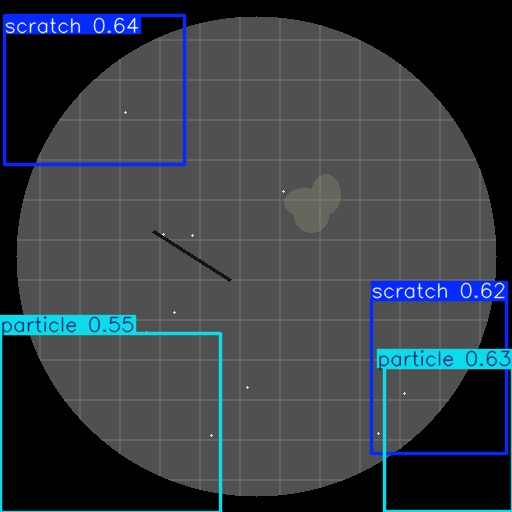


Result for: wafer_blob.jpg


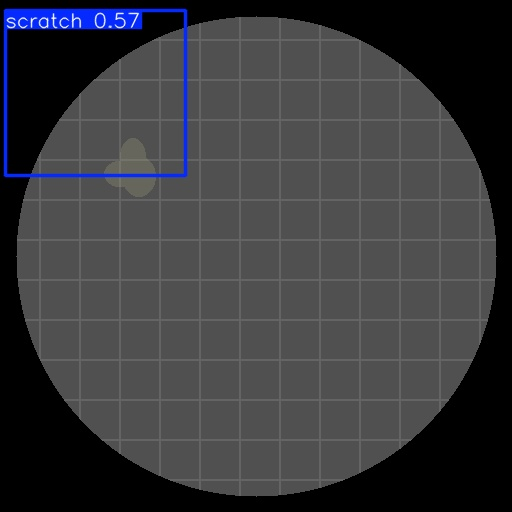


Result for: wafer_clean.jpg


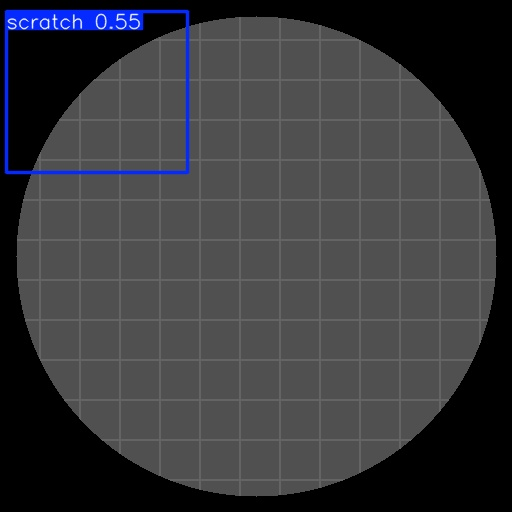


Result for: wafer_particles.jpg


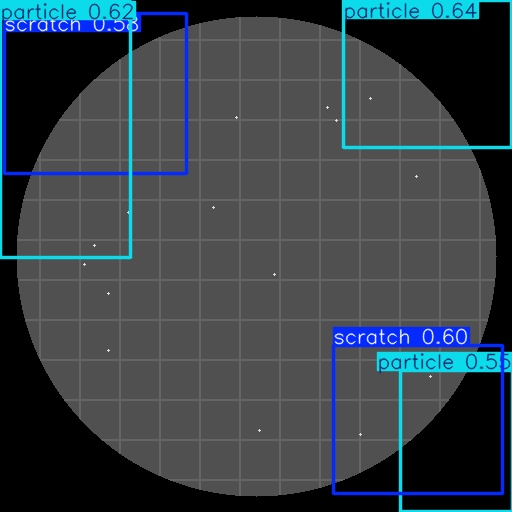


Result for: wafer_scratch.jpg


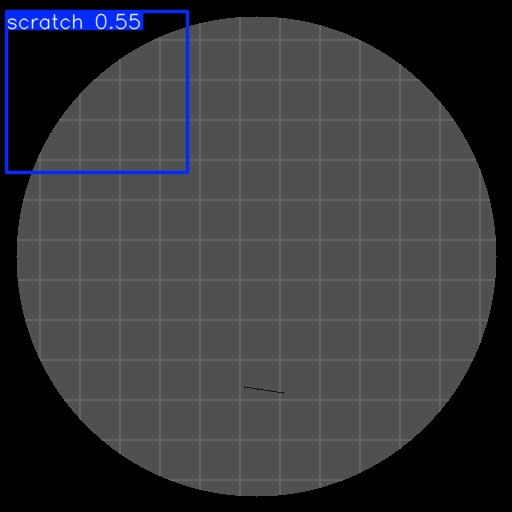

In [17]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Unzip the test images ---
print("Unzipping test images...")
!unzip -o test_images.zip -d test_images_unzipped
print("✅ Unzip complete.")

# --- Final Model Evaluation ---

# 1. Path to our ultimate trained model in your Google Drive.
model_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt'

# 2. Path to the test images folder.
test_images_folder = 'test_images_unzipped/test_images'

# 3. Load our final, powerful model.
print(f"\nLoading Silicon Sentinel from: {model_path}")
model = YOLO(model_path)
print("✅ Final model loaded successfully.")

# 4. Run prediction with our strict 0.5 confidence threshold.
print("\n🚀 Running FINAL predictions...")
results = model.predict(
    source=test_images_folder,
    save=True,
    conf=0.5
)
print("✅ Final predictions complete!")

# 5. Display the definitive results.
prediction_output_dir = results[0].save_dir
result_images = sorted(glob.glob(os.path.join(prediction_output_dir, '*.jpg')))

if not result_images:
    print("\nCould not find any result images.")
else:
    print("\n--- ✅ SILICON SENTINEL: FINAL RESULTS ---")
    for img_path in result_images:
        print(f"\nResult for: {os.path.basename(img_path)}")
        display(Image(filename=img_path))

In [20]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Final Showcase Generation ---
print("This is the final run. We will generate several sets of results for you to choose from.")

# The path to the ULTIMATE model, which is safely in your Google Drive
model_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt'
test_images_folder = 'test_images_unzipped/test_images'

if not os.path.exists(model_path):
    print(f"❌ ERROR: The final model was not found in your Google Drive at {model_path}")
else:
    model = YOLO(model_path)

    # We will test at three different confidence levels
    confidence_levels = [0.40, 0.25, 0.15]

    for conf in confidence_levels:
        print(f"\n🚀 Running prediction with confidence threshold = {conf}...")
        model.predict(
            source=test_images_folder,
            save=True,
            conf=conf,
            name=f"predict_at_{int(conf*100)}" # Saves to a unique folder like 'predict_at_25'
        )
        print(f"✅ Prediction run for conf={conf} complete!")

print("\n--- All showcase images have been generated. ---")
print("Please check the folders in 'runs/detect/' (e.g., 'predict_at_40', 'predict_at_25') to find your images.")

This is the final run. We will generate several sets of results for you to choose from.

🚀 Running prediction with confidence threshold = 0.4...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 3 scratchs, 2 particles, 16.2ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 3 scratchs, 16.3ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 3 scratchs, 16.3ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 3 scratchs, 4 particles, 16.2ms
image 5/5 /content/test_images_unzipped/test_images/wafer_scratch.png: 640x640 3 scratchs, 16.3ms
Speed: 2.8ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict_at_40
✅ Prediction run for conf=0.4 complete!

🚀 Running prediction with confidence threshold = 0.25...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 8 scratchs, 2 p